In [21]:
%load_ext autoreload
%autoreload 2
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import thor.data as data
import thor.data.dispatch as dispatch
import thor.grid as grid
import thor.track as track
import thor.option as option
import thor.tag as tag
import thor.visualize as visualize
import thor.utils as utils

notebook_name = "cpol_demo.ipynb"
__file__ = "/home/ewan/Documents/THOR/examples/cpol_demo.ipynb"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
# Parent directory for saving outputs
base_local = "/home/ewan/Documents/THOR/thor"

# Create the data_options dictionary
converted_options = {"save": False, "load": True, "parent_converted": None}
cpol_options = data.aura.cpol_data_options(
    start="2005-11-13T14:00:00",
    end="2005-11-13T16:00:00",
    converted_options=converted_options,
)
era5_pl_options = data.era5.data_options()
era5_sl_options = data.era5.data_options(data_format="single-levels")
data_options = option.consolidate_options(
    [cpol_options, era5_pl_options, era5_sl_options]
)

dispatch.check_data_options(data_options)
data.option.save_data_options(data_options, filename="cpol_era5")

# Create the grid_options dictionary using the first file in the cpol dataset
filepath = data_options["cpol"]["filepaths"][0]
with xr.open_dataset(filepath) as cpol:
    if converted_options["load"]:
        latitude, longitude = [cpol.latitude.values, cpol.longitude.values]
    else:
        lats = cpol["point_latitude"].isel(z=0).values
        lons = cpol["point_longitude"].isel(z=0).values
        latitude, longitude = grid.new_geographic_grid(lats, lons, 0.025, 0.025)
grid_options = grid.create_options(
    name="geographic", latitude=latitude, longitude=longitude
)
grid.check_options(grid_options)
grid.save_grid_options(grid_options, filename="cpol_geographic")

# Create the tag_options dictionary
era5_pl_tag_options = data.era5.tag_options()
era5_sl_tag_options = data.era5.tag_options(dataset="era5_sl")
tag_options = option.consolidate_options([era5_pl_tag_options, era5_sl_tag_options])
tag.save_tag_options(tag_options, filename="era5")

# Create the track_options dictionary
track_options = option.mcs(dataset="cpol", tags=["era5_pl", "era5_sl"])
option.save_track_options(track_options, filename="cpol_mcs")

# Create the display_options dictionary
visualize_options = {
    obj: visualize.option.runtime_options(
        obj,
        save=True,
        style="paper",
    )
    for obj in ["cell", "middle_cloud", "anvil"]
}
visualize.option.save_display_options(visualize_options, filename="runtime_mcs")

2024-06-27 19:40:29,639 - thor.option - DEBUG - Saving options to /home/ewan/THOR_output/options/data_options/cpol_era5.yaml
2024-06-27 19:40:29,689 - thor.option - DEBUG - Saving options to /home/ewan/THOR_output/options/grid_options/cpol_geographic.yaml
2024-06-27 19:40:29,706 - thor.option - DEBUG - Saving options to /home/ewan/THOR_output/options/tag_options/era5.yaml
2024-06-27 19:40:29,713 - thor.option - DEBUG - Saving options to /home/ewan/THOR_output/options/track_options/cpol_mcs.yaml
2024-06-27 19:40:29,727 - thor.option - DEBUG - Saving options to /home/ewan/THOR_output/options/visualize_options/runtime_mcs.yaml


In [25]:
times = data.aura.generate_cpol_times(data_options["cpol"]["filepaths"])
tracks = track.simultaneous_track(times, data_options, grid_options, track_options, tag_options, visualize_options)

2024-06-27 19:40:44,450 - thor.track - INFO - Processing 2005-11-13T14:00:09.000000000.
2024-06-27 19:40:44,451 - thor.data.aura - DEBUG - Updating cpol dataset for 2005-11-13T14:00:09.000000000
2024-06-27 19:40:44,476 - thor.track - DEBUG - Processing hierarchy level 0.
2024-06-27 19:40:44,477 - thor.track - DEBUG - Tracking cell.
2024-06-27 19:40:45,831 - thor.track - DEBUG - Tracking middle_cloud.
2024-06-27 19:40:46,841 - thor.track - DEBUG - Tracking anvil.
2024-06-27 19:40:47,773 - thor.track - DEBUG - Processing hierarchy level 1.
2024-06-27 19:40:47,774 - thor.track - DEBUG - Tracking mcs.
2024-06-27 19:40:47,774 - thor.data.era5 - DEBUG - Updating era5_pl dataset for 2005-11-13T14:00:09.000000000
2024-06-27 19:40:47,776 - thor.data.era5 - DEBUG - Subsetting u_era5_oper_pl_20051101-20051130.nc
2024-06-27 19:40:47,818 - thor.data.era5 - DEBUG - Subsetting v_era5_oper_pl_20051101-20051130.nc
2024-06-27 19:40:47,856 - thor.data.era5 - DEBUG - Subsetting z_era5_oper_pl_20051101-200

In [17]:
cpol_demo = xr.open_dataset('/home/ewan/Documents/THOR/thor/test/data/converted/cpol/cpol_level_1b/v2020/gridded/grid_150km_2500m/2005/20051113/twp10cpolgrid150.b2.20051113.184000.nc')
# x = cpol_demo.x.values
# y = cpol_demo.y.values
x = cpol_demo.longitude.values
y = cpol_demo.latitude.values
reflectivity = cpol_demo.reflectivity.values[0, 7]
background_radius = 11e3
radius_option = 1
delta_Z_option = 0
dBZ_threshold = 42

use_dBZ_threshold = True

In [30]:
from thor.detect.steiner import steiner_scheme, haversine

In [29]:
'latitude' in cpol_demo.dims

True

In [31]:
classification = steiner_scheme(reflectivity, x, y, coordinates="geographic")

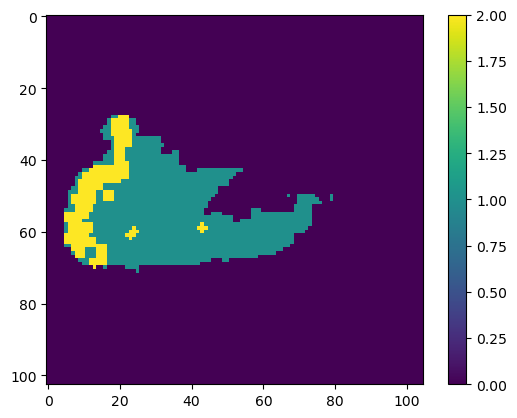

In [32]:
plt.imshow(classification)
plt.colorbar()